# Preprocessing

**Steps:**
1. The Denmark LPIS vector geometries are cleaned and simplified, the labels are reclassified to 1 classes.
2. The Sentinel-2 RGB-imagery is cut to 128x128-pixel image chips.
3. The prepared LPIS data is clipped to the chip geometries and saved in COCO annotation format.

Due to file size limitations, this repository only contains vector and satellite image data for a small subset of the full area of interest. The preprocessing of this demonstration data (area around Frederiksen, Denmark) results in 9 image chips. To work on the full dataset as presented in the thesis, you can download:
- [2016 LPIS dataset](https://kortdata.fvm.dk/download/Markblokke_Marker?page=MarkerHistoriske) ("Marker_2016_CVR.zip") via the Danish Ministery of Environment
- [Sentinel-2 mosaic](https://code.earthengine.google.com/c9ac3a79660b65525cfa59f1087cea9b) (2016/05/08, tiles 32VNH&T32UNG) via this Google Earth Engine script.

![](figures/preprocessing_demo.jpg)

In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import shapely
from pprint import pprint

import utils
from utils.other import new_pickle, load_pickle, new_json, load_json
from utils import coco , geo ,img , other

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Vector preparation 

In [44]:
inpath_s2 = Path(r'data/RGB_small.tif')
inpath_fields = Path(r'data/marker2016_small.shp')

outpath = Path(r'output/preprocessed')

In [45]:
def prepare_vector(fp, out_crs, clipping_bounds):
    df = (gpd.read_file(str(fp), encoding='cp865')  # danish encoding
             .rename(columns={'Afgroede': 'lc_name', 'AfgKode': 'lc_id', 'JOURNALNUM': 'journalnr'})
             .drop(['GB', 'GEOMETRISK', 'MARKNUMMER'], axis=1)
             .pipe(utils.geo.explode_mp)
             .pipe(utils.geo.buffer_zero)
             .pipe(utils.geo.close_holes)
             .pipe(utils.geo.set_crs, 3044)
             .to_crs(out_crs)
             .pipe(utils.geo.clip, clip_poly=shapely.geometry.box(*clipping_bounds), explode_mp_=True)
             .pipe(utils.geo.reclassify_col, rcl_scheme=utils.geo.reclass_legend, 
                   col_classlabels='lc_name', col_classids='lc_id', drop_other_classes=True)
             .assign(geometry=lambda _df: _df.geometry.simplify(5, preserve_topology=True))
             .pipe(utils.geo.buffer_zero)
             .assign(area_sqm=lambda _df: _df.geometry.area)
             .pipe(utils.geo.reduce_precision, precision=4)
             .reset_index(drop=True)
             .assign(fid=lambda _df: range(0, len(_df.index)))
             .filter(['journalnr', 'lc_id', 'lc_name', 'r_lc_id', 'r_lc_name', 'area_sqm', 'fid', 'geometry']))
    return df

outpath_fields = outpath / 'prepared_vector.shp'

if not outpath_fields.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
        raster_bounds = src.bounds
    df = prepare_vector(inpath_fields, raster_meta['crs'], raster_bounds)
    outpath_fields.parent.mkdir(parents=True, exist_ok=True)
    df.to_file(outpath_fields, driver='ESRI Shapefile', encoding='cp865')
else:
    print(f'Loading from exisiting shp file... {outpath_fields.name}')
    df = gpd.read_file(str(outpath_fields), encoding='cp865')
     
print(df.info())
display(df.head(3))

Loading from exisiting shp file... prepared_vector.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   journalnr  234 non-null    object  
 1   lc_id      234 non-null    object  
 2   lc_name    234 non-null    object  
 3   r_lc_id    234 non-null    int64   
 4   r_lc_name  234 non-null    object  
 5   area_sqm   234 non-null    float64 
 6   fid        234 non-null    int64   
 7   geometry   234 non-null    geometry
dtypes: float64(1), geometry(1), int64(2), object(4)
memory usage: 14.8+ KB
None


,journalnr,lc_id,lc_name,r_lc_id,r_lc_name,area_sqm,fid,geometry
0,16-0020644,1,Vσrbyg,1,field,6818.565562,0,"POLYGON ((516576.310 6243070.000, 516595.983 6..."
1,16-0036135,11,Vinterhvede,1,field,15477.545517,1,"POLYGON ((514093.879 6243688.645, 514192.096 6..."
2,16-0014547,280,Fodersukkerroer,1,field,54178.844742,2,"POLYGON ((515329.099 6243575.518, 515447.501 6..."


## Cut to chips

### Clip vectors to chip geometries

In [46]:
outpath_chips = outpath / 'chip_dfs.pkl'
chip_width, chip_height = 128, 128

if not outpath_chips.exists():
    with rasterio.open(inpath_s2) as src:
        raster_meta = src.meta
    chip_dfs = utils.geo.cut_chip_geometries(vector_df=df,
                                             raster_width=raster_meta['width'],
                                             raster_height=raster_meta['height'],
                                             raster_transform=raster_meta['transform'],
                                             chip_width=chip_width,
                                             chip_height=chip_height,
                                             first_n_chips = 1000)
    new_pickle(outpath_chips, chip_dfs)
else:
    chip_dfs = load_pickle(outpath_chips)
    
print('len', len(chip_dfs))

Loading from existing pickle file... chip_dfs.pkl
len 9


### Convert chip vectors to COCO annotation format (contains test/test split) and export.

In [47]:
train_chip_dfs, val_chip_dfs = utils.coco.train_test_split(chip_dfs, test_size=0.2, seed=1)
coco_train = utils.coco.format_coco(train_chip_dfs, chip_width, chip_height)
coco_val = utils.coco.format_coco(val_chip_dfs, chip_width, chip_height)
new_json(outpath / r'annotations/train2016.json', coco_train)
new_json(outpath / r'annotations/val2016.json', coco_val)

Writing new json file... train2016.json
Writing new json file... val2016.json


### Crop images to chips

In [48]:
# Cut to chip images and write to disk, retrieve chip image statistics
    
chip_windows = {chip_name : value['chip_window'] for chip_name, value in chip_dfs.items()}
chip_statistics = utils.img.cut_chip_images(inpath_raster=inpath_s2,
                                            outpath_chipfolder=outpath / r'images/train2016', 
                                            chip_names=chip_windows.keys(),
                                            chip_windows=chip_windows.values(), 
                                            bands=[3, 2, 1])

utils.coco.move_coco_val_images(inpath_train_folder=outpath / r'images/train2016',
                                val_chips_list=val_chip_dfs.keys())

print('len', len(chip_statistics))

9it [00:00, 230.88it/s]

chip is COCO_val2016_000000100005 and  and in path is : output/preprocessed/images/train2016
chip is COCO_val2016_000000100006 and  and in path is : output/preprocessed/images/train2016
len 9


## Save statistics & visualize results(optional)
The statistics are partially used as model training parameters.

In [49]:
statistics = {
    'nr_chips': len(chip_dfs.keys()),
    'nr_chips_train': len(train_chip_dfs),
    'nr_chips_val': len(val_chip_dfs),
    'nr_polys': sum([len(df['chip_df']) for df in chip_dfs.values()]),
    'nr_polys_train': sum([len(df['chip_df']) for df in train_chip_dfs.values()]),
    'nr_polys_val': sum([len(df['chip_df']) for df in val_chip_dfs.values()]),
    'avg_polys_per_chip': sum([len(df['chip_df']) for df in chip_dfs.values()]) / len(chip_dfs.keys()),
    'train_rgb_mean': list(np.asarray([df['mean'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0)),
    'train_rgb_std': list(np.asarray([df['std'] for df in [chip_statistics[key] for key in train_chip_dfs.keys()]]).mean(axis=0))}

new_json(outpath / 'statistics.json', statistics)
pprint(statistics)

Writing new json file... statistics.json
{'avg_polys_per_chip': 28.0,
 'nr_chips': 9,
 'nr_chips_train': 7,
 'nr_chips_val': 2,
 'nr_polys': 252,
 'nr_polys_train': 192,
 'nr_polys_val': 60,
 'train_rgb_mean': [94.87407575334821, 106.43259974888393, 117.06084333147321],
 'train_rgb_std': [29.676533028155795, 14.783947366623368, 14.194860301379379]}


output/preprocessed
Loading from existing json file... val2016.json
COCO_val2016_000000100005.jpg


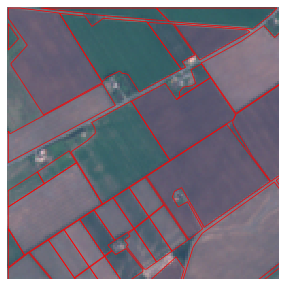

COCO_val2016_000000100006.jpg


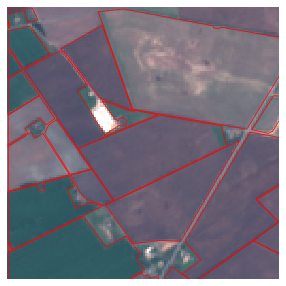

In [50]:
print(outpath)
utils.coco.plot_coco(inpath_json=outpath / r'annotations/val2016.json', 
                     inpath_image_folder=outpath / r'images/val2016', 
                     end=2)